# Import Libraries

In [1]:
import math
import random
import numpy as np
import pandas as pd
import sklearn
import seaborn as sns
import time

import matplotlib.pyplot as plt

import pickle
from functools import partial, update_wrapper

def wrapped_partial(func, *args, **kwargs):
    partial_func = partial(func, *args, **kwargs)
    update_wrapper(partial_func, func)
    return partial_func


from sklearn import preprocessing
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.metrics import classification_report, make_scorer, accuracy_score, balanced_accuracy_score, f1_score
from sklearn.pipeline import make_pipeline

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.svm import NuSVC
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF,Matern,RationalQuadratic,ExpSineSquared,DotProduct
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score


from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split

# Result storage

In [2]:
results_overview = {}
predictions_per_model = {}

# Data Loading

In [3]:
df_data_train = pd.read_csv('amazon_review_ID.shuf.lrn.csv', low_memory=False, sep=',')
df_data_res = pd.read_csv('amazon_review_ID.shuf.tes.csv', low_memory=False, sep=',')


class_factor = df_data_train['Class'].factorize()
class_index = class_factor[1]


df_data_train = df_data_train.replace('?', np.nan)
# drop the NaN
df_data_train = df_data_train.dropna(axis=0, how="any")

output_train=df_data_train['Class']

X = df_data_train.drop(labels=['Class'], axis=1)

#X= preprocessing.scale(X)

X_train, X_test, y_train, y_test = train_test_split(X, output_train, random_state = 0, test_size=0.33)


df_data_res = df_data_res.replace('?', np.nan)
# drop the NaN
X_res = df_data_res.dropna(axis=0, how="any")


In [4]:
df_data_train.head()

,ID,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V9992,V9993,V9994,V9995,V9996,V9997,V9998,V9999,V10000,Class
0,0,16,8,8,5,7,3,2,4,2,...,0,0,1,0,0,0,0,1,0,Janson
1,1,15,11,10,9,7,10,3,2,4,...,0,0,0,0,0,0,1,0,0,Robert
2,2,8,4,4,8,0,3,0,2,1,...,0,0,0,0,0,0,0,0,0,Kolln
3,3,14,6,11,10,5,7,11,2,6,...,0,0,0,0,0,0,1,0,0,Riley
4,4,10,7,8,5,15,6,6,3,3,...,0,0,0,0,0,0,1,0,0,Comdet


## Class Distribution

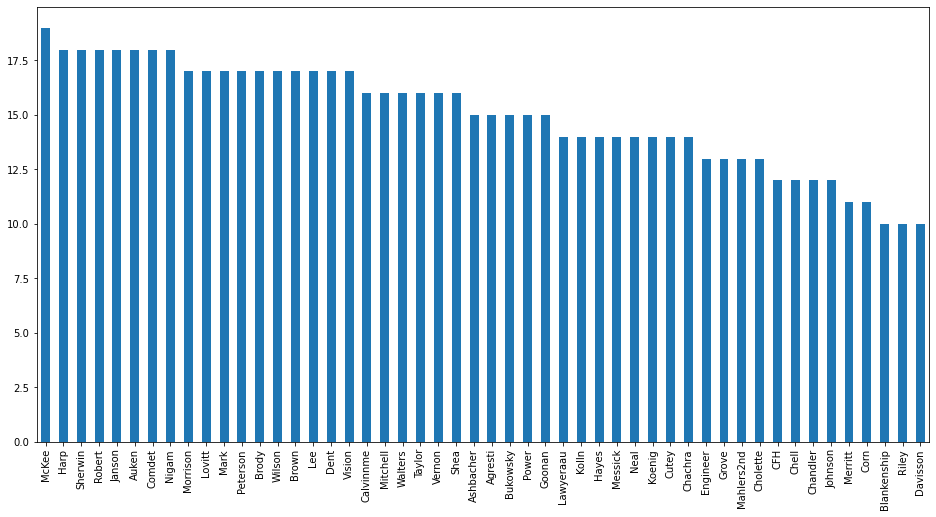

McKee          19
Harp           18
Sherwin        18
Robert         18
Janson         18
Auken          18
Comdet         18
Nigam          18
Morrison       17
Lovitt         17
Mark           17
Peterson       17
Brody          17
Wilson         17
Brown          17
Lee            17
Dent           17
Vision         17
Calvinnme      16
Mitchell       16
Walters        16
Taylor         16
Vernon         16
Shea           16
Ashbacher      15
Agresti        15
Bukowsky       15
Power          15
Goonan         15
Lawyeraau      14
Kolln          14
Hayes          14
Messick        14
Neal           14
Koenig         14
Cutey          14
Chachra        14
Engineer       13
Grove          13
Mahlers2nd     13
Cholette       13
CFH            12
Chell          12
Chandler       12
Johnson        12
Merritt        11
Corn           11
Blankenship    10
Riley          10
Davisson       10
Name: Class, dtype: int64

50

In [5]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(16,8))
output_train.value_counts().plot(kind='bar')
plt.show()

display(output_train.value_counts())
display(len(output_train.value_counts()))

## Modelselection

In [6]:
#do not run again
'''models = [SGDClassifier(),KNeighborsClassifier(),GaussianProcessClassifier(),MLPClassifier(),
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]

CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, X, output_train, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])


sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

cv_df.groupby('model_name').accuracy.mean()
'''

'models = [SGDClassifier(),KNeighborsClassifier(),GaussianProcessClassifier(),MLPClassifier(),\n    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),\n    LinearSVC(),\n    MultinomialNB(),\n    LogisticRegression(random_state=0),\n]\n\nCV = 5\ncv_df = pd.DataFrame(index=range(CV * len(models)))\nentries = []\nfor model in models:\n  model_name = model.__class__.__name__\n  accuracies = cross_val_score(model, X, output_train, scoring=\'accuracy\', cv=CV)\n  for fold_idx, accuracy in enumerate(accuracies):\n    entries.append((model_name, fold_idx, accuracy))\ncv_df = pd.DataFrame(entries, columns=[\'model_name\', \'fold_idx\', \'accuracy\'])\n\n\nsns.boxplot(x=\'model_name\', y=\'accuracy\', data=cv_df)\nsns.stripplot(x=\'model_name\', y=\'accuracy\', data=cv_df, \n              size=8, jitter=True, edgecolor="gray", linewidth=2)\nplt.show()\n\ncv_df.groupby(\'model_name\').accuracy.mean()\n'

# Linear Model

In [7]:
'''
#dont run again

clf = LinearSVC()

parameter_grid = {
    'penalty': ['l2', 'l1'],
    'loss': ['hinge', 'squared_hinge']
}
cv_grid = GridSearchCV(clf, parameter_grid, cv=3, verbose=10, n_jobs=-1, scoring=['accuracy', 'balanced_accuracy', 'f1_weighted'], refit='accuracy')
cv_grid.fit(X, output_train)

print("Best Parameter Choice:")
print(cv_grid.best_params_)
'''

'\n#dont run again\n\nclf = LinearSVC()\n\nparameter_grid = {\n    \'penalty\': [\'l2\', \'l1\'],\n    \'loss\': [\'hinge\', \'squared_hinge\']\n}\ncv_grid = GridSearchCV(clf, parameter_grid, cv=3, verbose=10, n_jobs=-1, scoring=[\'accuracy\', \'balanced_accuracy\', \'f1_weighted\'], refit=\'accuracy\')\ncv_grid.fit(X, output_train)\n\nprint("Best Parameter Choice:")\nprint(cv_grid.best_params_)\n'

In [8]:
clf = make_pipeline(LinearSVC(loss = 'squared_hinge', penalty = 'l2' ))

clf.fit(X, output_train)

# CV
cv_result = cross_validate(clf, X, output_train, cv=3, scoring = ['accuracy', 'balanced_accuracy', 'f1_weighted'], n_jobs=-1)

results_overview['LinearSVC'] = {
    'accuracy': cv_result['test_accuracy'].mean(),
    'balanced_accuracy': cv_result['test_balanced_accuracy'].mean(),
    'f1_weighted': cv_result['test_f1_weighted'].mean(),
    'fit_time' : cv_result['fit_time'].mean()
    }

/Users/johannesdorsch/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


KeyboardInterrupt: 

In [ ]:
clf2 = make_pipeline(LinearSVC(loss = 'squared_hinge', penalty = 'l2' ))

clf2.fit(X_train, y_train)

results_overview['LinearSVC']['Holdout'] = accuracy_score(y_test,clf2.predict(X_test))

display(results_overview)

# Predict
y_prediction = clf.predict(X_res)
y_houldout_prediction = clf2.predict(X_res)


In [ ]:
f = open("linear_result.csv", "a")
f.write('ID,"Class"\n')
for i in range(750):
    f.write(str(i+750)+','+y_prediction[i]+'\n')
f.close()

f = open("linear_result2.csv", "a")
f.write('ID,"Class"\n')
for i in range(750):
    f.write(str(i+750)+','+y_houldout_prediction[i]+'\n')
f.close()

## Logistic Model

In [ ]:
#do not run again
'''clf = LogisticRegression()

parameter_grid = {
    'penalty': ['l2', 'none'],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'max_iter': [50, 100, 200,250]
}
cv_grid = GridSearchCV(clf, parameter_grid, cv=3, verbose=10, n_jobs=-1, scoring=['accuracy', 'balanced_accuracy', 'f1_weighted'], refit='accuracy')
cv_grid.fit(X, output_train)

print("Best Parameter Choice:")
print(cv_grid.best_params_)'''

In [16]:
clf = make_pipeline(LogisticRegression(max_iter= 50, penalty = 'none', solver = 'sag' ))

clf.fit(X, output_train)

# CV
cv_result = cross_validate(clf, X, output_train, cv=3, scoring = ['accuracy', 'balanced_accuracy', 'f1_weighted'], n_jobs=-1)

results_overview['LogRegression'] = {
    'accuracy': cv_result['test_accuracy'].mean(),
    'balanced_accuracy': cv_result['test_balanced_accuracy'].mean(),
    'f1_weighted': cv_result['test_f1_weighted'].mean(),
    'fit_time' : cv_result['fit_time'].mean()
    }

/Users/johannesdorsch/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


In [17]:
clf2 = make_pipeline(LogisticRegression(max_iter= 250, penalty = 'none', solver = 'sag' ))

clf2.fit(X_train, y_train)

results_overview['LogRegression']['Holdout'] = accuracy_score(y_test,clf2.predict(X_test))

display(results_overview)

# Predict
y_prediction = clf.predict(X_res)
y_houldout_prediction = clf2.predict(X_res)

In [18]:
f = open("log_result.csv", "a")
f.write('ID,"Class"\n')
for i in range(750):
    f.write(str(i+750)+','+y_prediction[i]+'\n')
f.close()

f = open("log_result2.csv", "a")
f.write('ID,"Class"\n')
for i in range(750):
    f.write(str(i+750)+','+y_houldout_prediction[i]+'\n')
f.close()

# Random Forest

In [6]:
#do not run again
clf = RandomForestClassifier()

parameter_grid = {
    'criterion' : ['gini', 'entropy'],
    'max_features' : ['auto', 'sqrt', 'log2']
}
cv_grid = GridSearchCV(clf, parameter_grid, cv=3, verbose=10, n_jobs=-1, scoring=['accuracy', 'balanced_accuracy', 'f1_weighted'], refit='accuracy')
cv_grid.fit(X, output_train)

print("Best Parameter Choice:")
print(cv_grid.best_params_)


Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   17.8s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   25.1s
[Parallel(n_jobs=-1)]: Done  13 out of  18 | elapsed:   30.0s remaining:   11.5s
[Parallel(n_jobs=-1)]: Done  15 out of  18 | elapsed:   34.1s remaining:    6.8s
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:   36.9s finished


Best Parameter Choice:
{'criterion': 'gini', 'max_features': 'auto'}


In [13]:
clf = make_pipeline(RandomForestClassifier(criterion= 'gini',max_features = 'auto'))

clf.fit(X, output_train)

# CV
cv_result = cross_validate(clf, X, output_train, cv=3, scoring = ['accuracy', 'balanced_accuracy', 'f1_weighted'], n_jobs=-1)

results_overview['RandomForestClassifier'] = {
    'accuracy': cv_result['test_accuracy'].mean(),
    'balanced_accuracy': cv_result['test_balanced_accuracy'].mean(),
    'f1_weighted': cv_result['test_f1_weighted'].mean(),
    'fit_time' : cv_result['fit_time'].mean()
    }

In [14]:
clf2 = make_pipeline(cv_grid.best_estimator_)

clf2.fit(X_train, y_train)

results_overview['RandomForestClassifier']['Holdout'] = accuracy_score(y_test,clf2.predict(X_test))

display(results_overview)

# Predict
y_prediction = clf.predict(X_res)
y_houldout_prediction = clf2.predict(X_res)

{'RandomForestClassifier': {'accuracy': 0.5146666666666667,
  'balanced_accuracy': 0.511968253968254,
  'f1_weighted': 0.4883289933435444,
  'fit_time': 7.754329363505046}}

In [15]:
f = open("RandomTree_result.csv", "w")
f.write('ID,"Class"\n')
for i in range(750):
    f.write(str(i+750)+','+y_prediction[i]+'\n')
f.close()

f = open("RandomTree_result2.csv", "a")
f.write('ID,"Class"\n')
for i in range(750):
    f.write(str(i+750)+','+y_houldout_prediction[i]+'\n')
f.close()

## Kneighbors

In [ ]:
#do not run again
clf = KNeighborsClassifier()

parameter_grid = {
    'weights':['uniform', 'distance']
}
cv_grid = GridSearchCV(clf, parameter_grid, cv=3, verbose=10, n_jobs=-1, scoring=['accuracy', 'balanced_accuracy', 'f1_weighted'], refit='accuracy')
cv_grid.fit(X, output_train)

print("Best Parameter Choice:")
print(cv_grid.best_params_)



In [ ]:
clf = make_pipeline(cv_grid.best_estimator_)

clf.fit(X, output_train)

# CV
cv_result = cross_validate(clf, X, output_train, cv=3, scoring = ['accuracy', 'balanced_accuracy', 'f1_weighted'], n_jobs=-1)

results_overview['NeighborsClassifier'] = {
    'accuracy': cv_result['test_accuracy'].mean(),
    'balanced_accuracy': cv_result['test_balanced_accuracy'].mean(),
    'f1_weighted': cv_result['test_f1_weighted'].mean(),
    'fit_time' : cv_result['fit_time'].mean()
    }



In [ ]:
clf2 = make_pipeline(cv_grid.best_estimator_)

clf2.fit(X_train, y_train)

results_overview['NeighborsClassifier']['Holdout'] = accuracy_score(y_test,clf2.predict(X_test))

display(results_overview)

# Predict
y_prediction = clf.predict(X_res)
y_houldout_prediction = clf2.predict(X_res)

In [ ]:
f = open("NeighborsClassifier_result.csv", "a")
f.write('ID,"Class"\n')
for i in range(750):
    f.write(str(i+750)+','+y_prediction[i]+'\n')
f.close()

f = open("NeighborsClassifier_result2.csv", "a")
f.write('ID,"Class"\n')
for i in range(750):
    f.write(str(i+750)+','+y_houldout_prediction[i]+'\n')
f.close()

In [ ]:
pd.DataFrame.from_dict(results_overview).T